In [1]:
import numpy as np
import pandas as pd
import re 
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as prof
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from fuzzywuzzy import utils
from fuzzywuzzy.string_processing import StringProcessor

In [2]:
df = pd.read_csv('/home/hassaan/Data/TUM/2nd Year/4th Semester/IDP/Project/data/intermediate/consolidated_end116.csv')
df = df.drop(columns=['Unnamed: 0']) 
df.head()

,cid,personName,year,orgid,orgname,industry,asset_type,min,max,hidemax,type,lobbies,contributes,folderOfOrigin
0,N00000939,Nadler-Jerrold,2014,D000000103,JPMorgan Chase & Co,Commercial Banks,NaN,15001,50000,0,Y,Y,NaN,cong111
1,N00000939,Nadler-Jerrold,2014,D000021792,HSBC Bank,Commercial Banks,Cash/Money Market/Savings/Checking,1001,15000,0,Y,NaN,NaN,cong111
2,N00000939,Nadler-Jerrold,2014,NaN,Congressional Federal Credit Union Account,Unknown,Cash/Money Market/Savings/Checking,1001,15000,0,Y,NaN,NaN,cong111
3,N00000939,Nadler-Jerrold,2011,D000021792,HSBC Bank,Commercial Banks,Cash/Money Market/Savings/Checking,15001,50000,0,Y,NaN,NaN,cong111
4,N00000939,Nadler-Jerrold,2011,D000000103,JPMorgan Chase & Co,Commercial Banks,NaN,1001,15000,0,Y,Y,NaN,cong111


In [3]:
prof.ProfileReport(df)

Number of variables,14
Number of observations,245582
Total Missing (%),21.6%
Total size in memory,26.2 MiB
Average record size in memory,112.0 B
Numeric,3
Categorical,10
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [4]:
companiesDF = pd.read_csv('/home/hassaan/Data/TUM/2nd Year/4th Semester/IDP/Project/data/intermediate/comp_firms.csv')
companiesDF.head()

,gvkey,conm,conml,state
0,1000,A & E PLASTIK PAK INC,A & E Plastik Pak Inc,NaN
1,1001,A & M FOOD SERVICES INC,A & M Food Services Inc,OK
2,1002,AAI CORP,AAI Corp,MD
3,1003,A.A. IMPORTING CO INC,A.A. Importing Co Inc,MO
4,1004,AAR CORP,AAR Corp,IL


### Separating categories in DF

In [5]:
print(df['asset_type'].unique())
df['asset_type'].describe()

[nan 'Cash/Money Market/Savings/Checking' 'Brokerage, IRA, 401k'
 'Government Bond' 'Unknown'
 '"Account" or Combination of other types (I.e.Stocks & Bonds)'
 'Insurance policies & Annuities' 'Mutual Fund' 'Note/Note Receivable']


count          116493
unique              8
top       Mutual Fund
freq            67111
Name: asset_type, dtype: object

In [6]:
# print(df['Government Bond'].unique())
df[df['asset_type']=='Government Bond'].describe()

,year,min,max,hidemax
count,14224.000000,1.422400e+04,1.422400e+04,14224.000000
mean,2009.601659,1.259635e+05,2.858318e+05,0.024184
std,3.244377,5.522883e+05,1.127839e+06,0.153627
min,2004.000000,0.000000e+00,3.000000e+00,0.000000
25%,2007.000000,2.002000e+03,1.500000e+04,0.000000
50%,2010.000000,1.800400e+04,5.000000e+04,0.000000
75%,2012.000000,1.000010e+05,2.500000e+05,0.000000
max,2015.000000,5.000000e+07,5.000000e+07,1.000000


In [7]:
# assetTypes = df['asset_type'].unique()
# industryTypes = df['industry'].unique()
# yearTypes = df['year'].unique()

#### looking at government bonds compared to everything

<BarContainer object of 4 artists>

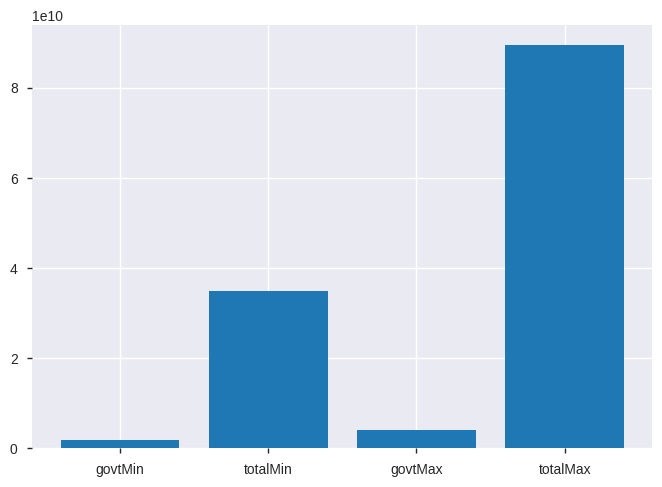

In [8]:
govtBonds = df[df['asset_type']=='Government Bond']
bars = ['govtMin', 'totalMin', 'govtMax', 'totalMax']
heights = [np.sum(govtBonds['min'].values), np.sum(df['min'].values), np.sum(govtBonds['max'].values), np.sum(df['max'].values)]
plt.bar(bars, heights)

In [9]:
filteredDF = df[df['asset_type']!='Government Bond']
print(len(filteredDF))

231358


#### Govt. bonds have been removed - Sub-divide into types of assets and match sub-strs

In [10]:
#remove digit starting companies

print('Total starting: ', len(filteredDF))
congOrgs = filteredDF['orgname'].unique()

pattern = re.compile('^[0-9][0-9]\+?%\s')  #testing  regex (https://www.regextester.com/94730)
percentMatches = [x for x in congOrgs if pattern.findall(x)]
print('companies with "% " start-string: ', len(percentMatches))

pattern = re.compile('^[0-9]')  #testing  regex (https://www.regextester.com/94730)
numMatches = [x for x in congOrgs if pattern.findall(x)]
print('companies with numeric start-string: ', len(numMatches))

print('Intersections: ', list(set(percentMatches).intersection(numMatches)))

numMatches = list(set(numMatches) - set(list(set(numMatches).intersection(percentMatches))))
print('companies with numeric start-string with out percent: ', len(numMatches))

Total starting:  231358
companies with "% " start-string:  20
companies with numeric start-string:  2185
Intersections:  ['50% interest in part of Parcel III, Lot', '50% Interest 152 Acre Farm', '25% Interest Inherited from the Settlement of the', '50% Interest 4 Acres/Rockwall, TX', '50% Interest In Lot 9/Searchlight, NV', '50% Interest 4 Acres 1500 Sunset Hill, TX', '25% interest in ZLDR partnership owning 95 acres +', '50% Interest 152 Acre Heart County, TX - Farm', '10% interest in Trott-ATA LLC', '20% Interest Travis Webb', '50% Interest 4 Acres', '50% Templeton Foreign Fund 50% Artisan T', '50% 3/5 interest in 21.06 Acres', '50% of 78 Acres of land in Jeff Davis, MS', '50% Interest 152 Acres/Hunt County, TX', '20% of the outstanding units of Foundtainhead Part', '50% of 1/4 undivided interest 400 Acre Tract- Bent', '15% interest in Legal Press, LLC', '10% Wealth Management LLC', '50% 3/5 interest in 21.06 Acres Description: 13/4/']
companies with numeric start-string with out per

In [11]:
# removing numeric starting strings
print('Records deleted from the filtered dataframe: ', len(filteredDF[filteredDF.orgname.isin(numMatches)]))#will 
#differ from removed company names because records are repeated over several congressi for the number of 
#times a particular senator was elected

filteredDF = filteredDF[~filteredDF.orgname.isin(numMatches)] # ~ emulates not isin()
print('After removing numeric starting assests: ', len(filteredDF))

Records deleted from the filtered dataframe:  4804
After removing numeric starting assests:  226554


In [ ]:
len(filteredDF.orgname.unique())

In [ ]:
def strMatch(searchVal, indexList, l1_thresh=85, l2_thresh=90, _size=5):
    matches = []
    baseList = process.extract(searchVal, indexList, limit=_size)
    for _str, conf in baseList:
        if float(conf)>l1_thresh:
            match = fuzz.partial_ratio(searchVal, _str)
            if float(match)>l2_thresh:
                matches.append((_str, match))
    return baseList, matches

In [ ]:
def statCal(queryList, companiesList, paramList):
    
    queryCount = len(queryList)
    companyCount = len(companiesList)
    paramCount = len(paramList)
    count = 0
    resultList = []
    for thresh in paramList:
        savePath = '/home/hassaan/Data/TUM/2nd Year/4th Semester/IDP/Project/data/intermediate/thresh_test/QC'+str(queryCount)+'_l1TH89'+'_l2TH'+str(thresh)
        match_dict = {}
        baseList_dict = {}
        tempQueue = []
        print('T1:', thresh)
        for searchVal in queryList:
            base, match = strMatch(searchVal=searchVal, indexList=companiesList, l1_thresh=89, l2_thresh=thresh)
            baseList_dict[searchVal] = base
    
            if match:
                tempQueue.append(1)
                match_dict[searchVal] = match[0]
                
            else:
                tempQueue.append(0)
                match_dict[searchVal] = np.nan
        
#         matchedDF = pd.DataFrame({'congOrg':queryList, 'match':match_dict.values(), 'base':baseList_dict.values()})#(match_dict.items(), columns=['congOrgs', 'match'])
        matchedDF = pd.DataFrame(match_dict.items(), columns=['congOrgs', 'match'])
        baseListDF = pd.DataFrame(baseList_dict.items(), columns=['congOrgs', 'baseList'])
        matchedDF.to_csv(savePath+'_ml.csv')
        baseListDF.to_csv(savePath+'_bl.csv')
        
        resultList.append( (float(np.sum(tempQueue))/queryCount)*100 ) #percentage matches
        
#         print(resultList)
#         print(matchedDF.head())
#         print(baseListDF.head())
#         break
        count+=1
        print('progress:', (float(count)/paramCount)*100 )
        
    return resultList

In [ ]:
import time
sampleDF = filteredDF.sample(n=200) 

start = time.time()
filteredResults = statCal(queryList=sampleDF.orgname.unique(), companiesList=companiesDF.conml.unique(), paramList = list(range(75, 96, 2)))
end = time.time()
print('Time taken in minutes: ', float(end - start)/60)

In [ ]:
print(filteredResults)

In [ ]:
plt.plot( list(range(75, 96, 2)), filteredResults )
plt.show()

In [ ]:
# sampleDF = df.sample(n=500) 
# originalResults = statCal(queryList=sampleDF.orgname.unique(), companiesList=companiesDF.conml.unique(), paramList = list(range(75, 96, 2)))

In [ ]:
sampleDF = filteredDF.sample(n=200) 

start = time.time()
filteredResults_t2 = statCal(queryList=sampleDF.orgname.unique(), companiesList=companiesDF.conml.unique(), paramList = list(range(75, 96, 2)))
end = time.time()
print('Time taken in minutes: ', float(end - start)/60)

In [ ]:
print(filteredResults_t2)
plt.plot( list(range(75, 96, 2)), filteredResults_t2 )
plt.show()

In [34]:
pd.DataFrame({'t1': filteredResults, 't2': filteredResults_t2}).to_csv('comparitive_results_for_thresh_plotting.csv')